# **Modelos Benchmarks**

In [1]:
# Librerias Importadas

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

In [5]:
# Cargar datos
df = pd.read_csv(r"C:\Jupyter-Books\EDA\16-21.csv")

columns_to_drop = ['CODIGO_ENTIDAD','NOMBRE_ENTIDAD', 'NOMBRE_TIPO_PATRIMONIO','NOMBRE_PATRIMONIO','TIPO_PARTICIPACION', 'CODIGO_NEGOCIO', 'TIPO_NEGOCIO', 'ANULACIONES','NUMERO_INVERSIONISTAS','NUMERO_UNIDADES_FONDO_CIERRE_OPER_DIA_T_ANTERIOR','VALOR_UNIDAD_OPERACIONES_DIA_T']

df = df.drop(columns=columns_to_drop, errors='ignore')

df.head()

,FECHA_CORTE,TIPO_ENTIDAD,NOMBRE_TIPO_ENTIDAD,SUBTIPO_NEGOCIO,NOMBRE_SUBTIPO_PATRIMONIO,PRINCIPAL_COMPARTIMENTO,RENDIMIENTOS_ABONADOS,PRECIERRE_FONDO_DIA_T,APORTES_RECIBIDOS,RETIROS_REDENCIONES,VALOR_FONDO_CIERRE_DIA_T,RENTABILIDAD_DIARIA,RENTABILIDAD_MENSUAL,RENTABILIDAD_SEMESTRAL,RENTABILIDAD_ANUAL
0,2016-01-01,5,SF-SOCIEDAD FIDUCIARIA,1,FIC DE TIPO GENERAL,1,1.225369e+08,9.303540e+11,0.0,0.0,9.303540e+11,4.925178,4.540000,3.020000,3.190000
1,2016-01-01,5,SF-SOCIEDAD FIDUCIARIA,7,FONDOS DE CAPITAL PRIVADO,1,2.678000e+02,1.370691e+11,0.0,0.0,1.370691e+11,0.000071,7.398338,47.588044,25.129215
2,2016-01-01,85,COMISIONISTAS DE BOLSA DE VALORES,1,FIC DE TIPO GENERAL,1,3.267797e+05,1.142338e+10,0.0,0.0,1.142338e+10,1.049611,-4.692300,0.631400,3.371184
3,2016-01-01,85,COMISIONISTAS DE BOLSA DE VALORES,7,FONDOS DE CAPITAL PRIVADO,2,-6.025692e+05,7.128130e+09,0.0,0.0,7.128130e+09,-3.038200,5.764400,0.000000,0.000000
4,2016-01-01,85,COMISIONISTAS DE BOLSA DE VALORES,1,FIC DE TIPO GENERAL,1,-4.057828e+04,5.055087e+08,0.0,0.0,5.055087e+08,-2.887314,145.398140,0.000000,0.000000


In [5]:
# Número de ceros en la varibable 'RETIROS_REDENCIONES'
num_zeros = (df['RETIROS_REDENCIONES'] == 0).sum()
print(f"Número de ceros en 'RETIROS_REDENCIONES': {num_zeros}")

Número de ceros en 'RETIROS_REDENCIONES': 916781


In [5]:
# Definir variables predictoras y respuesta
X = df[["APORTES_RECIBIDOS", "PRECIERRE_FONDO_DIA_T", "VALOR_FONDO_CIERRE_DIA_T", "TIPO_ENTIDAD"]]
y = df["RETIROS_REDENCIONES"]

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
# Inicializar modelos
models = {
    "K-NN": KNeighborsRegressor(n_neighbors=5),
    "Linear Regression": LinearRegression()
}

# Diccionario para almacenar métricas
results = []

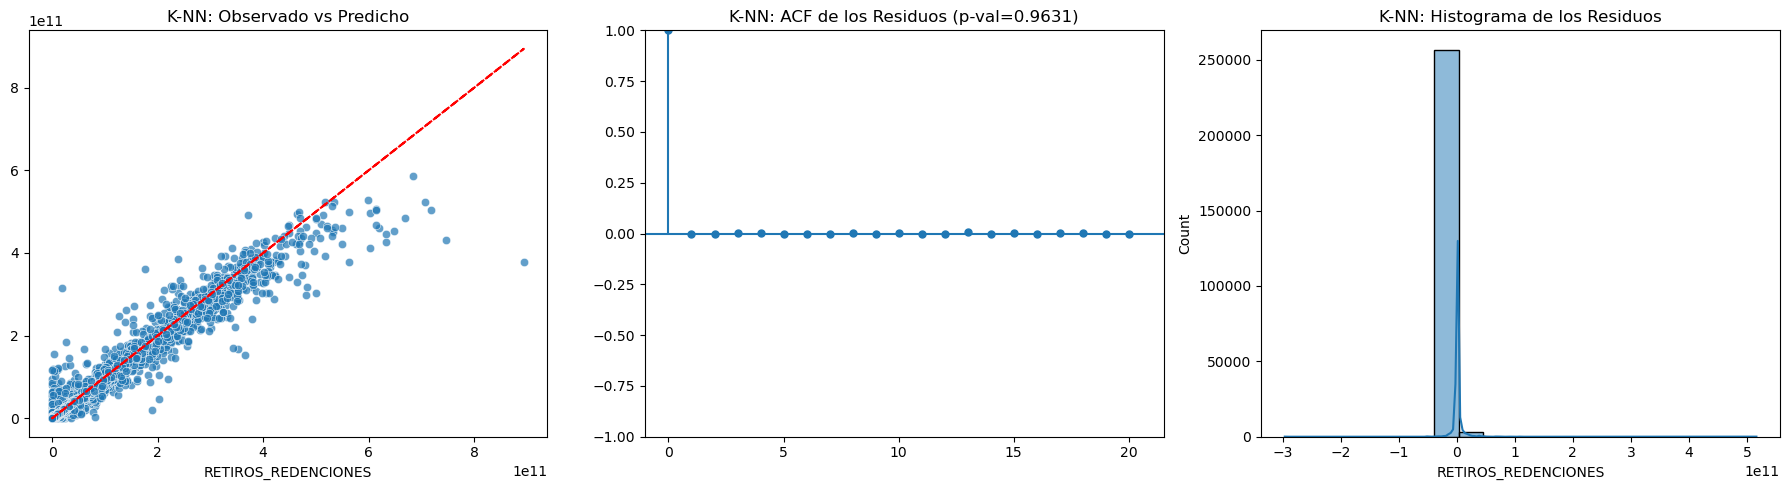

KeyboardInterrupt: 

In [ ]:
for name, model in models.items():
    start_time = time.time()
    
    # Entrenar modelo
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = model.predict(X_test)
    
    # Métricas
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Residuales
    residuals = y_test - y_pred
    ljung_pval = acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_pvalue"].values[0]
    
    # Tiempo de ejecución
    elapsed_time = time.time() - start_time
    
    results.append([name, mape, rmse, r2, ljung_pval, elapsed_time])
    
    # --- Graficar resultados ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Curva de valores reales vs predichos
    sns.scatterplot(x=y_test, y=y_pred, ax=axes[0], alpha=0.7)
    axes[0].plot(y_test, y_test, color='red', linestyle='--')
    axes[0].set_title(f"{name}: Observado vs Predicho")
    
    # 2. ACF de los residuos
    sm.graphics.tsa.plot_acf(residuals, lags=20, ax=axes[1])
    axes[1].set_title(f"{name}: ACF de los Residuos (p-val={ljung_pval:.4f})")
    
    # 3. Histograma de residuos
    sns.histplot(residuals, kde=True, ax=axes[2])
    axes[2].set_title(f"{name}: Histograma de los Residuos")
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Convertir resultados a DataFrame
columns = ["Modelo", "MAPE", "RMSE", "$R^2$", "Ljung-Box p-value", "Tiempo (s)"]
df_results = pd.DataFrame(results, columns=columns)
print(df_results)

              Modelo          MAPE          RMSE     $R^2$  Ljung-Box p-value  \
0               K-NN  3.054218e+22  3.453016e+09  0.969221           0.963145   
1  Linear Regression  5.062833e+22  1.878637e+09  0.990889           0.000105   

   Jarque-Bera p-value  Tiempo (s)  
0                  0.0    7.704763  
1                  0.0    0.142433  
